In [1]:
import numpy as np
import torch
from torch import nn
import time
import matplotlib.pyplot as plt
from ukf import *
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [2]:
class EV_dataset(Dataset):
    def __init__(
            self,
            overall_path,
            trip_path,
            v_nums : list = [0],
            routes : list = [0]
    ):
        super(EV_dataset, self).__init__()
        self.overall_data = pd.read_csv(overall_path)
        self.trip_data = pd.read_csv(trip_path)
        self.trip_data['trip_velocity'] = self.trip_data['trip_dist'] / self.trip_data['trip_duration']

        self.dist_minmax = (self.overall_data['trip_dist'].min(), self.overall_data['trip_dist'].max())
        self.velo_minmax = (self.trip_data['trip_velocity'].min(), self.trip_data['trip_velocity'].max())
        self.load_minmax = (self.trip_data['trip_load'].min(), self.trip_data['trip_load'].max())
        self.volt_minmax = (self.overall_data['trip_v'].min(), self.overall_data['trip_v'].max())
        self.overall_data['trip_dist'] = (self.overall_data['trip_dist'] - self.dist_minmax[0]) / (self.dist_minmax[1] - self.dist_minmax[0])
        self.trip_data['trip_velocity'] = (self.trip_data['trip_velocity'] - self.velo_minmax[0]) / (self.velo_minmax[1] - self.velo_minmax[0])
        self.trip_data['trip_load'] = (self.trip_data['trip_load'] - self.load_minmax[0]) / (self.load_minmax[1] - self.load_minmax[0])
        self.overall_data['trip_v'] = (self.overall_data['trip_v'] - self.volt_minmax[0]) / (self.volt_minmax[1] - self.volt_minmax[0])

        self.v_nums = ['V' + str(i) for i in v_nums]
        self.routes = routes
        self.overall_data = self.overall_data.loc[(self.overall_data['vin'].isin(self.v_nums)) & (self.overall_data['route'].isin(self.routes))]
        self.trip_data = self.trip_data.loc[(self.trip_data['vin'].isin(self.v_nums)) & (self.trip_data['route'].isin(self.routes))]

    def normalizing_factor(self):
        print('Return (min, max) of trip_dist, trip_velocity, trip_load, trip_v')
        return [self.dist_minmax, self.velo_minmax, self.load_minmax, self.volt_minmax]


    def __len__(self):
        return self.overall_data.shape[0]
    
    def __getitem__(self, idx):
        x = self.overall_data.iloc[idx]
        v_num = x['vin']
        route = x['route']
        t = self.trip_data.loc[(self.trip_data['vin'] == v_num) & (self.trip_data['route'] == route)]
        trip_velocity = t['trip_velocity'].item()
        trip_dist = x['trip_dist'].item()
        trip_load = t['trip_load'].item()
        target_voltage = np.expand_dims(np.array(x['trip_v'].item(), dtype=np.float32), axis=0)
        return np.array([trip_velocity, trip_dist, trip_load], dtype=np.float32), target_voltage
    

overall_path = 'C:/Users/user/project/generate_ev_data/data/overall_pd.csv'
trip_path = 'C:/Users/user/project/generate_ev_data/data/trip_pd.csv'
v_nums = [i for i in range(100)]
routes = [0]

ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
print(len(ev_dataset))

23595


In [4]:
def get_f(name: str = "tanh") -> nn.Module:
    activations = nn.ModuleDict(
        [
            ["lrelu", nn.LeakyReLU(0.1)],
            ["relu", nn.ReLU()],
            ["tanh", nn.Tanh()],
        ]
    )
    return activations[name]

def dense_block(layers : list(), activation: str) -> nn.Sequential:
    out = list()
    for idx, (in_f, out_f) in enumerate(zip(layers, layers[1:])):
        if idx == len(layers) - 2:
            out.append(nn.Linear(in_f, out_f, bias=False))
        else:
            out.append(nn.Linear(in_f, out_f))
            if activation is not None:
                out.append(get_f(activation))
    return nn.Sequential(*out)

class neural_network(nn.Module):
    def __init__(
            self,
            layers = None,
            input_dim = 1025, 
            hidden_dim = 1000, 
            output_dim = 1025, 
            n_layers = 8,
            activation = 'relu'
            ):
        super(neural_network, self).__init__()
        self.layers = [input_dim] + [hidden_dim] * n_layers + [output_dim]
        if layers:
            self.layers = layers
        self.net = dense_block(self.layers, activation)

    def forward(self, x):
        
        return self.net(x)


In [5]:
model = neural_network(input_dim=3, hidden_dim=8, output_dim=1, n_layers=5, activation='relu', layers=[3, 4, 8, 16, 8, 4, 1])

# print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)
loss = torch.nn.functional.l1_loss

In [6]:
v_nums = [i for i in range(100)]
routes = [0]
ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
train_loader = DataLoader(ev_dataset, batch_size=256, shuffle=True)
epochs = 40

# loss_history = [[], []]

# start_time = time.time()
# for _ in range(epochs):
#     model.train()
#     train_loss = 0
#     for inp, tar in train_loader:
#         optimizer.zero_grad()
#         output = model(inp)
#         l = loss(output, tar)
#         l.backward()
#         optimizer.step()
#         train_loss += l.item()
#     train_loss /= len(train_loader)

#     loss_history[0].append(_)
#     loss_history[1].append(train_loss)

#     if (_ % 5 == 0) or (_+1 == epochs):
#         print(f'epoch num {_} loss : {train_loss}')

# print(f'time : {time.time() - start_time : .2f}')


In [7]:
# plt.plot(loss_history[0], loss_history[1], label='train_loss')
# plt.legend()
# plt.xlabel('Epoch number')
# plt.ylabel('MAE loss')
# plt.show()

In [8]:
# torch.save({
#     'epoch' : epochs,
#     'model_state_dict' : model.state_dict(),
#     'optimizer_state_dict' : optimizer.state_dict(),
#     'loss' : loss
# }, 'initial_model.pt')

In [9]:
checkpoint = torch.load('initial_model.pt')
print(checkpoint.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


In [10]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
epoch = checkpoint['epoch']

In [11]:
v0_model = deepcopy(model)
v0_optimizer = torch.optim.Adam(params=v0_model.parameters(), lr = 0.001)

v_nums = [0]
routes = [0]
ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
train_loader = DataLoader(ev_dataset, batch_size=256, shuffle=True)
epochs = 40

loss_history = [[], []]

start_time = time.time()
for _ in range(epochs):
    v0_model.train()
    train_loss = 0
    for inp, tar in train_loader:
        v0_optimizer.zero_grad()
        output = v0_model(inp)
        l = loss(output, tar)
        l.backward()
        v0_optimizer.step()
        train_loss += l.item()
    train_loss /= len(train_loader)

    loss_history[0].append(_)
    loss_history[1].append(train_loss)

    if (_ % 5 == 0) or (_+1 == epochs):
        print(f'epoch num {_} loss : {train_loss}')

print(f'time : {time.time() - start_time : .2f}')

epoch num 0 loss : 0.0024081431329250336
epoch num 5 loss : 0.004918306600302458
epoch num 10 loss : 0.0024582487531006336
epoch num 15 loss : 0.0031650704331696033
epoch num 20 loss : 0.0024220901541411877
epoch num 25 loss : 0.0022746503818780184
epoch num 30 loss : 0.002042799023911357
epoch num 35 loss : 0.002111521316692233
epoch num 39 loss : 0.0019157773349434137
time :  4.71


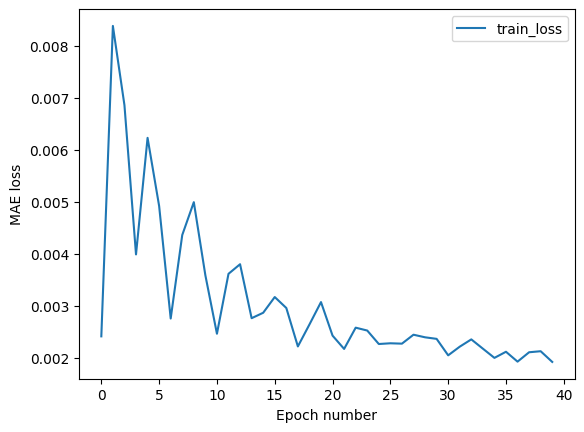

In [12]:
plt.plot(loss_history[0], loss_history[1], label='train_loss')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('MAE loss')
plt.show()

In [14]:
v_nums = [0]

loss_hist = [[], [], [], []]

for route_num in range(1, 100):
    routes = [route_num]
    ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
    train_loader = DataLoader(ev_dataset, batch_size=128, shuffle=True)

    # initial model
    l_0, l_1 = 0, 0
    for inp, tar in train_loader:
        output_ = model(inp)
        i_loss = loss(output_, tar)
        l_0 += i_loss.item()

        output_0 = v0_model(inp)
        v0_loss = loss(output_0, tar)
        l_1 += v0_loss.item()
    l_0 /= len(train_loader)
    l_1 /= len(train_loader)

    if l_1 > 0.05:
        print(f'model updated at route number {route_num}')
        loss_hist[3].append(route_num)
        for i in range(epochs):
            l_1 = 0
            for inp, tar in train_loader:
                v0_optimizer.zero_grad()
                output = v0_model(inp)
                v0_loss = loss(output, tar)
                v0_loss.backward()
                v0_optimizer.step()
                l_1 += v0_loss.item()
            l_1 /= len(train_loader)


    loss_hist[0].append(route_num)
    loss_hist[1].append(l_0)
    loss_hist[2].append(l_1)


model updated at route number 14
model updated at route number 25
model updated at route number 38
model updated at route number 44
model updated at route number 53
model updated at route number 61
model updated at route number 66
model updated at route number 71
model updated at route number 72
model updated at route number 76
model updated at route number 80
model updated at route number 83
model updated at route number 86
model updated at route number 89
model updated at route number 91
model updated at route number 93
model updated at route number 95
model updated at route number 97


In [15]:
print(f'model updated {len(loss_hist[3])} times after initial model')

model updated 18 times after initial model


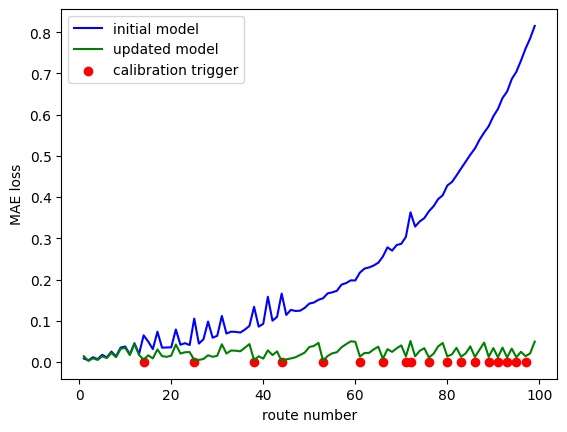

In [16]:
plt.plot(loss_hist[0], loss_hist[1], label = 'initial model', c='b')
plt.plot(loss_hist[0], loss_hist[2], label = 'updated model', c='g')
plt.scatter(loss_hist[3], [0 for _ in loss_hist[3]], label = 'calibration trigger', c='r')
plt.legend()
plt.xlabel('route number')
plt.ylabel('MAE loss')
plt.show()